In [98]:
import requests
import tempfile
import shutil
import subprocess
import shlex
import os
import sqlite3
import pandas
import xml.etree.cElementTree as etree

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Stack Exchange Analysis

# Introduction

We will analyze the components of questions and answers on Stack Exchange in order to understand what determines the quality of an answer. We will begin by understanding our data by predicting correlations in the data and evaluating our predictions by graphing the data. We will then begin to analyze the data by learning to predict several features. We will then work to predict the quality score of an answer given other features.

## Table of Contents

* [Processing the Data](#Processing-the-Data)
    * [Downloading the Data](#Downloading-the-data)
* [Predictions](#Predictions)
* [Answer Quality](#Answer-Quality)

# Processing the Data

## Downloading the data
Our first step is to download the [data dumps](https://archive.org/details/stackexchange). Currently, the Stack Exchange Network hosts their data dumps through the [Internet Archive](https://archive.org/). Dump files are provided for each network (aside from StackOverflow for which there are multiple files) and are compressed using the 7z archive format. Thus, the code below to download and uncompress the data archive requires having the `7z` binary, acquirable through `apt-get`, `brew` and other package managers.

In [99]:
def get_network_data(network, path=''):
    '''downloads StackExchange network data from archive.org'''

    # download archive
    url = 'https://archive.org/download/stackexchange/%s.stackexchange.com.7z' % network
    response = requests.get(url)
    
    with tempfile.NamedTemporaryFile('wb') as f:
        # copy 7z archive into the filesystem
        response.raw.decode_content = False
        f.write(response.content)
        f.flush()
        
        # create a folder to store the XML data
        path = os.path.join(path, network)
        if not os.path.exists(path):
            os.makedirs(path)

        # there are few Python 7z compatible libraries and they don't
        # work correctly with these archives (overwrite switch enabled)
        args = shlex.split('7z x %s -aoa "-o%s"' % (f.name, path))
        return subprocess.check_call(args)

In [100]:
network = 'arduino'
get_network_data(network)

0

## Creating the Database

Now that we've downloaded the archive, it's time to load the XML data within it into a database that can be easily queried when we're building our features. The [README](https://ia800500.us.archive.org/22/items/stackexchange/readme.txt) provided with the data dump describes the schema of each table and below we provide a visualization of these tables as well as the types of each field once we load them into our database. This visualization was created with the use of [WWW SQL Designer](https://ondras.zarovi.cz/sql/demo/). We note that the `posts` table covers both answers and questions and that `badges` are awards of a sort that users recieve for achieving certain milestones. While we deemphasize some of these tables throughout the feature engineering process, we nevertheless mention them here and process them for the sake of completeness.

![Database schema](schema.png)

Next, we create a SQLite database conforming to the above schema (duplicated below as a Python dictionary). Inspiration is taken from [zhangqiaorjc/sedumpy](https://github.com/zhangqiaorjc/sedumpy/blob/master/makedb.py).

In [78]:
schema = {
    'badges': {
        'Id': 'INTEGER PRIMARY KEY',
        'UserId': 'INTEGER',
        'Name': 'VARCHAR(50)',
        'Date': 'DATETIME',
        'Class': 'INTEGER',
        'TagBased': 'VARCHAR(8)',
    },
    'comments': {
        'Id': 'INTEGER PRIMARY KEY',
        'PostId': 'INTEGER',
        'Score': 'INTEGER',
        'Text': 'TEXT',
        'CreationDate': 'DATETIME',
        'UserId': 'INTEGER',
        'UserDisplayName': 'VARCHAR(256)',
    },
    'posts': {
        'Id': 'INTEGER PRIMARY KEY',
        'PostTypeId': 'INTEGER', # 1: Question, 2: Answer
        'ParentId': 'INTEGER', # present only if PostTypeId = 2
        'AcceptedAnswerId': 'INTEGER', # present only if PostTypeId = 1
        'CreationDate': 'DATETIME',
        'Score': 'INTEGER',
        'ViewCount': 'INTEGER',
        'Body': 'TEXT',
        'OwnerUserId': 'INTEGER', # present only if user has not been deleted
        'LastEditorUserId': 'INTEGER',
        'LastEditDate': 'DATETIME',
        'LastActivityDate': 'DATETIME',
        'Title': 'VARCHAR(256)',
        'Tags': 'VARCHAR(256)',
        'AnswerCount': 'INTEGER',
        'CommentCount': 'INTEGER',
        'FavoriteCount': 'INTEGER',
        'ClosedDate': 'DATETIME',
        'CommunityOwnedDate': 'DATETIME',
        'OwnerDisplayName': 'VARCHAR(256)',
        'LastEditorDisplayName': 'VARCHAR(256)',
    },
    'votes': {
        'Id': 'INTEGER PRIMARY KEY',
        'PostId': 'INTEGER',
        'UserId': 'INTEGER',
        'VoteTypeId': 'INTEGER',
            # 1: AcceptedByOriginator
            # 2: UpMod
            # 3: DownMod
            # 4: Offensive
            # 5: Favorite
            # 6: Close
            # 7: Reopen
            # 8: BountyStart
            # 9: BountyClose
            # 10: Deletion
            # 11: Undeletion
            # 12: Spam
            # 13: InformModerator
        'CreationDate': 'DATETIME',
        'BountyAmount': 'INTEGER',
    },
    'post_history': {
        'Id': 'INTEGER PRIMARY KEY',
        'PostHistoryTypeId': 'INTEGER',
        'PostId': 'INTEGER',
        'RevisionGUID': 'VARCHAR(36)',
        'CreationDate': 'DATETIME',
        'UserId': 'INTEGER',
        'Comment': 'TEXT',
        'Text': 'TEXT',
        'UserDisplayName': 'VARCHAR(256)',
    },
    'post_links': {
        'Id': 'INTEGER PRIMARY KEY',
        'CreationDate': 'DATETIME',
        'PostId': 'INTEGER',
        'RelatedPostId': 'INTEGER',
        'LinkTypeId': 'INTEGER',
    },
    'users': {
        'Id': 'INTEGER PRIMARY KEY',
        'Reputation': 'INTEGER',
        'CreationDate': 'DATETIME',
        'DisplayName': 'VARCHAR(50)',
        'LastAccessDate': 'DATETIME',
        'WebsiteUrl': 'VARCHAR(256)',
        'Location': 'VARCHAR(256)',
        'Age': 'INTEGER',
        'AboutMe': 'TEXT',
        'Views': 'INTEGER',
        'UpVotes': 'INTEGER',
        'DownVotes': 'INTEGER',
        'AccountId': 'INTEGER',
        'ProfileImageUrl': 'VARCHAR(256)',
    },
    'tags': {
        'Id': 'INTEGER PRIMARY KEY',
        'TagName': 'TEXT',
        'Count': 'INTEGER',
        'ExcerptPostId': 'INTEGER',
        'WikiPostId': 'INTEGER',
    }
}

def create_table(c, name, constraints=[]):
    '''Creates a single table under the schema given its name and constraints'''
    fields = list(map(lambda x: '%s %s' % x, schema[name].items()))
    c.execute(
        'CREATE TABLE %s (%s)' % (
            name,
            ', '.join(fields + constraints)
        )
    )

def create_database(network, path='', database=None):
    '''Creates a database containing all the Stack Exchange network data'''
    
    # choose a name for the database
    if not database:
        database = '%s.db' % network
    database = os.path.join(path, database)
    
    conn = sqlite3.connect(database)
    
    c = conn.cursor()
    
    create_table(c, 'users')
    create_table(c, 'badges', ['FOREIGN KEY(UserId) REFERENCES users(Id)'])
    create_table(c, 'posts', [
        'FOREIGN KEY(AcceptedAnswerId) REFERENCES posts(Id)',
        'FOREIGN KEY(ParentId) REFERENCES posts(Id)',
        'FOREIGN KEY(OwnerUserId) REFERENCES users(Id)'
    ])
    create_table(c, 'votes', [
        'FOREIGN KEY(PostId) REFERENCES posts(Id)',
        'FOREIGN KEY(UserId) REFERENCES users(Id)'
    ])
    create_table(c, 'tags', [
        'FOREIGN KEY(WikiPostId) REFERENCES posts(Id)',
        'FOREIGN KEY(ExcerptPostId) REFERENCES posts(Id)'
    ])
    create_table(c, 'comments', [
        'FOREIGN KEY(PostId) REFERENCES posts(Id)',
        'FOREIGN KEY(UserId) REFERENCES users(Id)'
    ])
    create_table(c, 'post_history', [
        'FOREIGN KEY(PostId) REFERENCES posts(Id)',
        'FOREIGN KEY(UserId) REFERENCES users(Id)'
    ])
    create_table(c, 'post_links', [
        'FOREIGN KEY(PostId) REFERENCES posts(Id)',
    ])
    
    conn.commit()
    
    return (conn, database)


In [79]:
conn, database = create_database(network)

### Creating Database Indices

We then create a series of indices to make our later queries faster,

In [80]:
def create_indices(conn):
    '''creates indices on the tables to speed up later queries'''
    c = conn.cursor()

    c.execute('CREATE INDEX badges_idx_1 ON badges(UserId);')

    c.execute('CREATE INDEX comments_idx_1 ON comments(PostId);')
    c.execute('CREATE INDEX comments_idx_2 ON comments(UserId);')

    c.execute('CREATE INDEX post_history_idx_1 ON post_history(PostId);')
    c.execute('CREATE INDEX post_history_idx_2 ON post_history(UserId);')

    c.execute('CREATE INDEX posts_idx_1 ON posts(AcceptedAnswerId);')
    c.execute('CREATE INDEX posts_idx_2 ON posts(ParentId);')
    c.execute('CREATE INDEX posts_idx_3 ON posts(OwnerUserId);')
    c.execute('CREATE INDEX posts_idx_4 ON posts(LastEditorUserId);')

    c.execute('CREATE INDEX votes_idx_1 ON votes(PostId);')
    
    conn.commit()

In [81]:
create_indices(conn)

### Populating the Database

Finally, we populate the database, one XML file at a time:

In [82]:
def xml_file_name(path, table):
    '''returns the path to the XML file corresponding to a particular table'''
    return os.path.join(path, ''.join(map(str.capitalize, table.split('_'))) + '.xml')

def populate_data(conn, path):
    '''populates all the network data given a path to a folder containing the XML dump files'''
    c = conn.cursor()

    # iterate over each table
    for table in ['users', 'badges', 'posts', 'votes', 'tags', 'comments', 'post_history', 'post_links']:
        tree = etree.iterparse(xml_file_name(path, table))
        for _, record in tree:
            if record.attrib.values():
                query = 'INSERT INTO %s (%s) VALUES (%s)' % (
                    table, 
                    ', '.join(record.attrib.keys()),
                    ('?, ' * len(record.attrib.keys()))[:-2]
                )
                c.execute(query, record.attrib.values())
        conn.commit()

In [83]:
populate_data(conn, network)

Finally, let's do a little sanity checking to ensure that we've correctly populated the database:

In [84]:
def santity_check(conn, path):
    c = conn.cursor()

    entries = pandas.DataFrame(columns=['table', 'xml_entries', 'db_entries'])
    
    for table in schema.keys():
        tree = etree.iterparse(xml_file_name(path, table))
        xml_count = len(list(tree))
        db_count = c.execute('SELECT COUNT(*) FROM %s' % table).fetchone()[0]
        entries = entries.append([{'table': table, 'xml_entries': xml_count, 'db_entries': db_count}])
    
    entries['difference'] = (entries['xml_entries'] - entries['db_entries']).map(abs)
    return entries

In [85]:
santity_check(conn, network)

,table,xml_entries,db_entries,difference
0,votes,44385.0,44384.0,1.0
0,comments,37438.0,37437.0,1.0
0,post_history,55411.0,55410.0,1.0
0,post_links,973.0,972.0,1.0
0,tags,286.0,285.0,1.0
0,posts,20007.0,20006.0,1.0
0,badges,24065.0,24064.0,1.0
0,users,17971.0,17970.0,1.0


# Predictions

To begin to understand the data, we wanted to analyze several potential correlations. Notably, we anticipated correlations between:
* upvote proportion and length of text of answers, because we expect longer answers to be more detailed
* upvote proportion and upvotes + downvotes for questions/answers, because we expect a higher proportion of upvotes will correspond to more upvotes
* reputation and upvote proportion for questions/answers, because we expect users with a good reputation will provide better answers
* reputation and number of posts
* question tags and views/response time, because we expect some topics to be searched more often than others (todo)

We plotted scatter plots for each pair to visualize the data.

#### Upvote Proportion vs. Answer Length

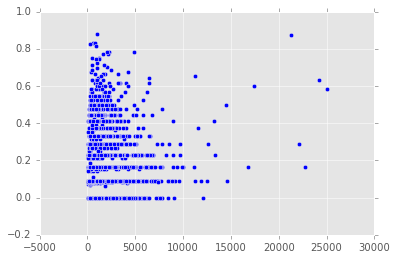

In [103]:
c = conn.cursor()

upvote_proportion = c.execute('''SELECT CAST ((
                                 SELECT COUNT(*) 
                                 FROM votes 
                                 WHERE votes.PostId = posts.Id AND VoteTypeId = 2
                             ) AS FLOAT) / ((
                                 SELECT COUNT(*) 
                                 FROM votes 
                                 WHERE votes.PostId = posts.Id AND VoteTypeId = 2
                             ) + (
                                 SELECT COUNT(*) 
                                 FROM votes 
                                 WHERE votes.PostId = posts.Id AND VoteTypeId = 3
                             ))
                         FROM posts
                         WHERE PostTypeId = 2
                         ORDER BY Id ASC''') #2 is upvote, 3 is downvote

upvote_proportion_arr = upvote_proportion.fetchall()

lengths = c.execute('''SELECT LENGTH(Body)
                         FROM posts
                         WHERE PostTypeId = 2
                         ORDER BY Id ASC''')

lengths_arr = lengths.fetchall()

p = plt.scatter(lengths_arr, upvote_proportion_arr)
plt.show()

#### Upvote Proportion vs. Total Votes

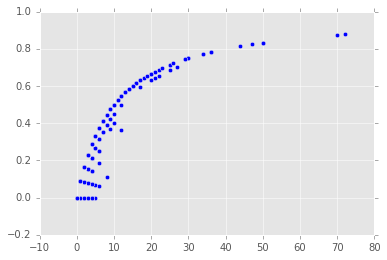

In [131]:
total_votes = c.execute('''SELECT (
                                 SELECT COUNT(*) 
                                 FROM votes 
                                 WHERE votes.PostId = posts.Id AND VoteTypeId = 2
                             ) + (
                                 SELECT COUNT(*) 
                                 FROM votes 
                                 WHERE votes.PostId = posts.Id AND VoteTypeId = 3
                             )
                         FROM posts
                         WHERE PostTypeId = 2
                         ORDER BY Id ASC''') #2 is upvote, 3 is downvote

total_votes_arr = total_votes.fetchall()

p = plt.scatter(total_votes_arr, upvote_proportion_arr)
plt.show()

#### Upvote Proportion vs. Answerer Reputation

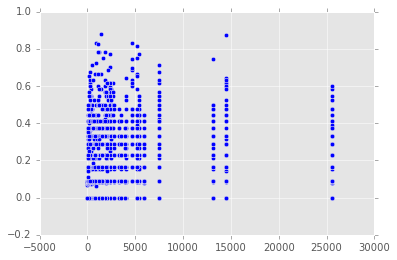

In [112]:
reputations = c.execute('''SELECT users.Reputation
                           FROM posts
                           LEFT JOIN users ON posts.OwnerUserId = users.Id
                           WHERE posts.PostTypeId = 2
                           ORDER BY posts.Id ASC''')

reputations_arr = reputations.fetchall()

p = plt.scatter(reputations_arr, upvote_proportion_arr)
plt.show()

#### Number of Posts vs. Reputation

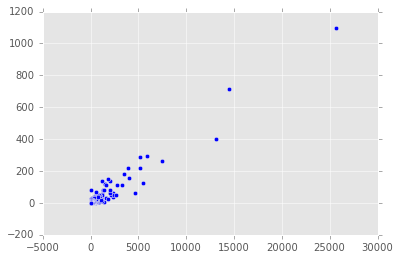

In [130]:
rep_by_user = c.execute('''SELECT Reputation
                           FROM users
                           ORDER BY Id''')

rep_by_user_arr = rep_by_user.fetchall()

num_posts = c.execute('''SELECT COUNT(posts.Id)
                         FROM users
                         LEFT JOIN posts ON users.Id = posts.OwnerUserId
                         GROUP BY users.Id
                         ORDER BY users.Id''') #this includes all posts, not just answers

num_posts_arr = num_posts.fetchall()

p = plt.scatter(rep_by_user_arr, num_posts_arr)
plt.show()

#### Mean Response Time vs. Tags

# Answer Quality

Now that we have a basic understanding of our data, we will try to understand the quality of an answer. We will measure answer quality in both:

$$upvotes$$

and

$$upvote\ proportion = \frac{upvotes}{upvotes + downvotes}$$

We must understand the following:

* Cause of Answerer Reputation, factors that correlate to Answerer Reputation
* (REMOVE) Relationship between quality score and total votes
* Difficulty of a question, measured in question text and response time
* Trends over time (year and month of year), measured in changes to Answer Quality and response time over time

And finally, we will determine:
* Answer Quality based on other features

## Understanding Answerer Reputation

## Quality score vs. total votes

## Difficulty of Question

## Trends over Time

## Relationship of features to Answer Quality